# 1. Librerías




In [11]:
import os
import numpy as np
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image
import functools

# 2. Imagen contenido e imagen estilo



## 2.1 Funciones necesarias

In [12]:
# Load an image and limit its maximum dimension to 512 pixels.
# NOT PART OF THE MODEL
def load_img(path_to_img, max_dim=512):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [13]:
# Display image
# NOT PART OF THE MODEL
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  plt.axis('off')
  if title:
    plt.title(title)

## 2.2 Cargar imágenes predeterminadas

In [14]:
# Choose a style image and a content image
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


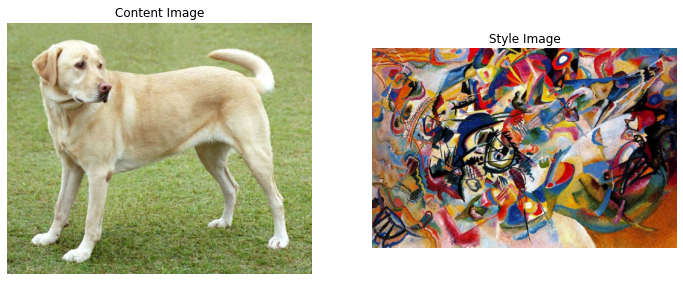

In [16]:
# Load images and display them
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## 2.3 Cargar imágenes propias

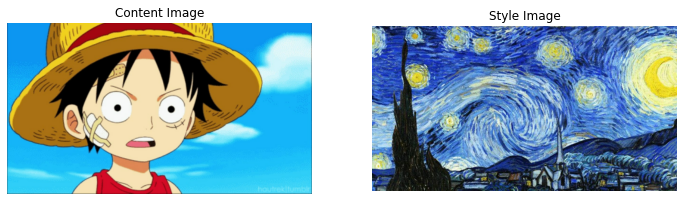

In [23]:
# Load images and display them
content_image = load_img('Dluffy.jpg')
style_image = load_img('vgstyle.jpg')

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# 3. Primer método

## 3.1 Cargar modelo pre-entrenada para construir el nuestro.

In [25]:
# Load pretrained VGG19 and test its performance
# NOT PART OF THE MODEL
x = tf.keras.applications.vgg19.preprocess_input(255 * content_image)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape # predicted a vector of 1000 classes (probabilities)

574717952/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [26]:
# Decode only the top5 most probable classes
# NOT PART OF THE MODEL
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]
# Labrador is the most probable class

40960/35363 [==================================] - 0s 0us/step


[('balloon', 0.19465563),
 ('oxygen_mask', 0.0794204),
 ('electric_fan', 0.077910714),
 ('comic_book', 0.06434193),
 ('pinwheel', 0.051823266)]

In [27]:
# Load model again, this time without classification layers
# NOT PART OF THE MODEL, but required to know the layer's names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 0s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [28]:
# Select hidden layers for the style and content of the image
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [29]:
# Create a vgg-like model with a list of intermediate output values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [30]:
# Create one model and plot it
# NOT PART OF THE MODEL
style_extractor = vgg_layers(style_layers)
style_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [31]:
# Apply model on the style image and see statistics of each layer's output
# NOT PART OF THE MODEL
style_outputs = style_extractor(255 * style_image)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 277, 512, 64)
  min:  0.0
  max:  803.7789
  mean:  32.824203

block2_conv1
  shape:  (1, 138, 256, 128)
  min:  0.0
  max:  3611.3354
  mean:  198.30978

block3_conv1
  shape:  (1, 69, 128, 256)
  min:  0.0
  max:  9949.163
  mean:  194.41792

block4_conv1
  shape:  (1, 34, 64, 512)
  min:  0.0
  max:  19611.4
  mean:  720.08734

block5_conv1
  shape:  (1, 17, 32, 512)
  min:  0.0
  max:  4083.1245
  mean:  60.29873



##  3.1 Calcule el estilo y el contenido

In [32]:
# Normalized Gram Matrix to measure correlations across the different feature maps
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  return result / (num_locations)

In [33]:
# Model to return style and content tensors
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = 255.0 * inputs
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [34]:
# Test it on the content image
# NOT PART OF THE MODEL
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.023334809
    max:  66883.79
    mean:  1690.8513

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  308493.1
    mean:  29660.246

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  1096428.9
    mean:  42083.453

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  9426068.0
    mean:  461435.28

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  177361.97
    mean:  3182.2964

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1872.8693
    mean:  21.266304


## 3.2 Optimización: descenso de gradiente

In [35]:
# Set style and content target values
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [36]:
# Make sure image is between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [37]:
# Define an optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [38]:
# Weight for each loss
style_weight=1e-2  # alpha de la presentación
content_weight=1e4 # beta  de la presentación

In [39]:
# Combined loss function
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                        for name in style_outputs.keys()])
  style_loss *= style_weight / len(style_layers)
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) 
                          for name in content_outputs.keys()])
  content_loss *= content_weight / len(content_layers)
  loss = style_loss + content_loss
  return loss

In [40]:
# Define a training step function with forward and backward passes
total_variation_weight = 30 # Hyperparameter

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image) # pixel gradients*

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
#* Penalize changes, makes image smooth

In [41]:
# Change tensor to image, so we can display it
# NOT PART OF THE MODEL, but required for displaying
def tensor_to_image(tensor):
  tensor = 255 * tensor
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [42]:
# Variable for the image to be optimized
image = tf.Variable(content_image)

# 4. Transferencia de estilo con el primer método


## 4.1 Transferencia de estilos por pasos

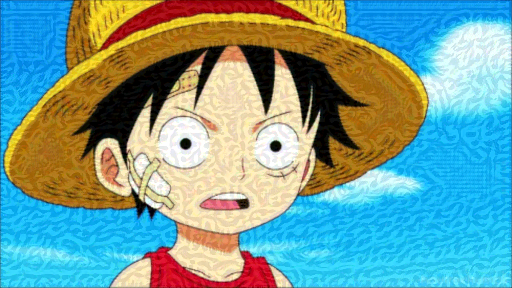

In [43]:
# Let's see whether it is working. Apply three optimization steps
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

## 4.2 Transferencia de estilos por épocas

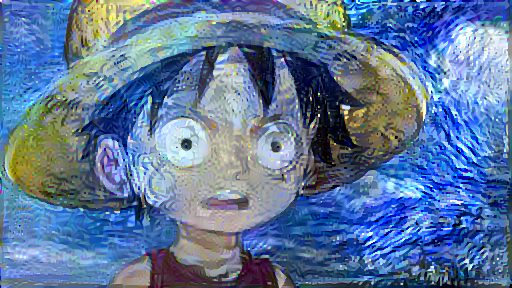

Train step: 1000
Total time: 56.9


In [49]:
# Train it for several more epochs
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# 5. Segundo método: TensorFlow Hub



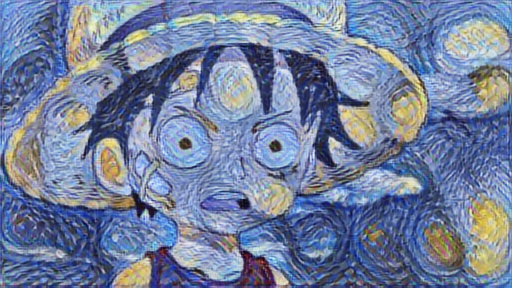

In [45]:
# Fast Style Transfer using TF-Hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED' # Load compressed models from tensorflow_hub
import tensorflow_hub as hub # Repo for several models
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2') # Get the model
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0] # Apply it on an image
tensor_to_image(stylized_image) # Visualize it